In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import datetime
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm, BoundaryNorm
from matplotlib.gridspec import GridSpec
import os

# Parametros (cambiar según sitio de estudio)
epsg = 32719
dates = ['1985-01-01', '2024-11-30']
region = 'Ohiggins'

# Rutas
base_path = 'data'
resumen = "RESUMEN"
ruta_resultados = fr'C:\Users\Rafael\Desktop\CoastSat-master\data\RESUMEN'



In [2]:
import os
import pandas as pd

# Base path donde se encuentran las carpetas de las playas
base_path = "data"  # Cambié aquí la ruta base

# Nombre de la carpeta a excluir
excluir_carpeta = "RESUMEN"

# Diccionario de playas con su código
diccionario_playas = {
    'PLAYA_MATANZAS': 'chi0345',
    'PLAYA_PUPUYA': 'chi0346',
    'PLAYA_PUERTECILLO': 'chi0347',
    'PLAYA_TOPOCALMA': 'chi0348',
    'PLAYA_SN1': 'chi0349',
    'PLAYA_SN2': 'chi0350',
    'PLAYA_SN3': 'chi0351',
    'PLAYA_TANUME': 'chi0352',
    'PLAYA_MONACO': 'chi0353',
    'PLAYA_PICHILEMU': 'chi0354',
    'PLAYA_INFIERNILLO': 'chi0355',
    'PLAYA_PUNTA_DE_LOBOS': 'chi0356',
    'PLAYA_CAHUIL': 'chi0357',
    'PLAYA_SN4': 'chi0358',
    'PLAYA_SN5': 'chi0359',
    'PLAYA_BUCALEMU': 'chi0360',
    'PLAYA_SN6': 'chi0361',
    'PLAYA_BOYERUCA': 'chi0362',
}

# Lista para almacenar los DataFrames de todas las playas
dataframes = []

# Iterar sobre el diccionario de playas en orden inverso
for sitename, codigo in reversed(diccionario_playas.items()):
    ruta_carpeta = os.path.join(base_path, sitename)
    
    # Verificar si la carpeta existe
    if os.path.isdir(ruta_carpeta):
        print(f"Carpeta encontrada: {sitename} ({codigo})")
        ruta_archivo = os.path.join(ruta_carpeta, 'transect_time_series_tidally_corrected.csv')
        
        # Verificar si el archivo existe
        if os.path.isfile(ruta_archivo):
            df = pd.read_csv(ruta_archivo)
            # Aseguramos que la columna de fechas esté en formato datetime (sin zona horaria)
            df['dates'] = pd.to_datetime(df['dates']).dt.tz_localize(None)  # Elimina la zona horaria
            # Cambiar los nombres de las columnas para incluir el código de la playa
            df = df.rename(columns=lambda col: f"{codigo}_{col}" if col != 'dates' else col)
            # Verificar columnas numéricas y aplicar interpolación

            dataframes.append(df)
        else:
            print(f"Archivo no encontrado: {ruta_archivo}")
    else:
        print(f"Carpeta no encontrada: {sitename}")

# Verificar si se han cargado DataFrames
if dataframes:
    # Combinar los DataFrames en uno solo, uniendo por la columna de fechas
    df_unificado = pd.concat(dataframes, axis=0).groupby('dates').first().reset_index()

    # Ruta para guardar el archivo unificado en la carpeta "RESUMEN"
    ruta_resumen_csv = os.path.join(base_path, excluir_carpeta, "archivo_unificado.csv")
    ruta_resumen_excel = os.path.join(base_path, excluir_carpeta, "archivo_unificado.xlsx")

    # Exportar el DataFrame unificado a un archivo CSV
    df_unificado.to_csv(ruta_resumen_csv, index=False)
    print(f"El archivo CSV unificado ha sido creado: {ruta_resumen_csv}")

    # Exportar el DataFrame unificado a un archivo Excel
    df_unificado.to_excel(ruta_resumen_excel, index=False)
    print(f"El archivo Excel unificado ha sido creado: {ruta_resumen_excel}")
else:
    print("No se han encontrado archivos para unificar.")


Carpeta encontrada: PLAYA_BOYERUCA (chi0362)
Carpeta encontrada: PLAYA_SN6 (chi0361)
Carpeta encontrada: PLAYA_BUCALEMU (chi0360)
Carpeta encontrada: PLAYA_SN5 (chi0359)
Carpeta encontrada: PLAYA_SN4 (chi0358)
Carpeta encontrada: PLAYA_CAHUIL (chi0357)
Carpeta encontrada: PLAYA_PUNTA_DE_LOBOS (chi0356)
Carpeta encontrada: PLAYA_INFIERNILLO (chi0355)
Carpeta encontrada: PLAYA_PICHILEMU (chi0354)
Carpeta encontrada: PLAYA_MONACO (chi0353)
Carpeta encontrada: PLAYA_TANUME (chi0352)
Carpeta encontrada: PLAYA_SN3 (chi0351)
Carpeta encontrada: PLAYA_SN2 (chi0350)
Carpeta encontrada: PLAYA_SN1 (chi0349)
Carpeta encontrada: PLAYA_TOPOCALMA (chi0348)
Carpeta encontrada: PLAYA_PUERTECILLO (chi0347)
Carpeta encontrada: PLAYA_PUPUYA (chi0346)
Carpeta encontrada: PLAYA_MATANZAS (chi0345)
El archivo CSV unificado ha sido creado: data\RESUMEN\archivo_unificado.csv
El archivo Excel unificado ha sido creado: data\RESUMEN\archivo_unificado.xlsx


In [3]:
import pandas as pd
import os

def rellenar_csv(input_csv_path, output_folder):
    """
    Carga un archivo CSV, rellena valores faltantes y guarda el resultado en formato CSV y Excel.

    Args:
        input_csv_path (str): Ruta del archivo CSV de entrada.
        output_folder (str): Carpeta donde se guardarán los archivos procesados.

    Returns:
        pd.DataFrame: DataFrame con los valores faltantes rellenados.
    """
    if not os.path.isfile(input_csv_path):
        raise FileNotFoundError(f"El archivo {input_csv_path} no existe.")

    # Cargar el archivo CSV
    df = pd.read_csv(input_csv_path)
    
    # Verificar si hay columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns
    if numeric_columns.empty:
        raise ValueError("No se encontraron columnas numéricas para procesar.")
    
    # Rellenar valores hacia adelante, hacia atrás y por interpolación
    df[numeric_columns] = df[numeric_columns].interpolate(method='nearest')
    df[numeric_columns] = df[numeric_columns].fillna(method='ffill').fillna(method='bfill')
    df[numeric_columns] = df[numeric_columns].interpolate(method='nearest')

    # Verificar si la carpeta de salida existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Generar rutas de salida
    base_name = os.path.basename(input_csv_path).replace('.csv', '')
    output_csv_path = os.path.join(output_folder, f"{base_name}_rellenado.csv")
    output_excel_path = os.path.join(output_folder, f"{base_name}_rellenado.xlsx")

    # Guardar los resultados
    df.to_csv(output_csv_path, index=False)
    print(f"Archivo CSV procesado guardado en: {output_csv_path}")
    
    df.to_excel(output_excel_path, index=False)
    print(f"Archivo Excel procesado guardado en: {output_excel_path}")

    return df


In [4]:
# Ruta del archivo CSV de entrada
input_csv = "data/RESUMEN/archivo_unificado.csv"

# Carpeta de salida para los resultados
output_folder = "data/RESUMEN"

# Llamar a la función
df_procesado = rellenar_csv(input_csv, output_folder)


C:\Users\Rafael\AppData\Local\Temp\ipykernel_17092\3238071478.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_columns] = df[numeric_columns].fillna(method='ffill').fillna(method='bfill')


Archivo CSV procesado guardado en: data/RESUMEN\archivo_unificado_rellenado.csv
Archivo Excel procesado guardado en: data/RESUMEN\archivo_unificado_rellenado.xlsx


In [5]:
# Ruta de la serie temporal de transectos, corregidos por marea
ruta_series = os.path.join(base_path, resumen, 'archivo_unificado_rellenado.csv')

serie = pd.read_csv(ruta_series, sep=',')
serie['dates'] = pd.to_datetime(serie['dates'])
serie.set_index('dates', inplace=True)
serie_interpolada = serie.interpolate()

# Extraer los nombres de las columnas de los transectos (todas las columnas excepto 'dates')
transectos = [col for col in serie.columns]

# Eliminar duplicados en caso de que haya transectos repetidos
transectos_unicos = list(set(transectos))

# Mostrar la lista de transectos únicos
seccion = len(transectos_unicos)
print(f'En la región de {region} hay {len(transectos_unicos)} transectos')

start_year = int(dates[0][0:4])
end_year = int(dates[1][0:4])
tiempo = range(start_year, end_year + 1)

En la región de Ohiggins hay 639 transectos


In [6]:
import pandas as pd

def calcular_valores_unicos_por_anio(file_path, diccionario_playas, fecha_columna='dates'):
    """
    Calcula la cantidad de valores únicos por año en las columnas numéricas de un archivo CSV.

    Args:
        file_path (str): Ruta del archivo CSV que contiene los datos.
        fecha_columna (str): Nombre de la columna de fechas en el archivo.

    Returns:
        dict: Diccionario con los años como claves y la cantidad de valores únicos como valores.
    """
    # Leer el archivo CSV
    df = pd.read_csv(file_path)

    # Asegurarse de que la columna de fechas esté en formato datetime
    if fecha_columna not in df.columns:
        raise ValueError(f"La columna '{fecha_columna}' no está en el archivo.")
    
    df[fecha_columna] = pd.to_datetime(df[fecha_columna], errors='coerce')
    
    if df[fecha_columna].isna().any():
        raise ValueError(f"La columna '{fecha_columna}' contiene valores de fecha no válidos.")
    
    # Extraer el año de las fechas
    df['year'] = df[fecha_columna].dt.year

    # Filtrar solo las columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Contar valores únicos por año en las columnas numéricas
    valores_unicos_por_anio = (df.groupby('year')[numeric_columns].nunique().sum(axis=1)-1)//len(transectos_unicos)
    return valores_unicos_por_anio


In [7]:
# Ruta al archivo unificado generado
ruta_archivo_unificado = "data/RESUMEN/archivo_unificado.csv"
# Calcular valores únicos por año
try:
    resultados = calcular_valores_unicos_por_anio(ruta_archivo_unificado, diccionario_playas)
    print("Cantidad de valores únicos por año en columnas numéricas:")
    print(resultados)
except Exception as e:
    print(f"Error al procesar el archivo: {e}")


Cantidad de valores únicos por año en columnas numéricas:
year
1985     0
1986     8
1987     4
1988     8
1989     6
1990     3
1991     6
1992     2
1993     4
1994     4
1995     4
1996     5
1997     3
1998     7
1999    10
2000    17
2001    23
2002    17
2003    22
2004    30
2005    22
2006    20
2007    23
2008    22
2009    20
2010    20
2011    18
2012    10
2013    21
2014    23
2015    33
2016    32
2017    52
2018    69
2019    72
2020    68
2021    64
2022    79
2023    72
2024    64
dtype: int64


In [8]:
def erotion_accretion_xt(diferencias, nombre, ruta, lista_playas):
    # Crear una figura con GridSpec para ajustar los tamaños
    fig = plt.figure(figsize=[25, 12])
    gs = GridSpec(2, 2, height_ratios=[0.25, 3], width_ratios=[2.5, 0.2])

    # Crear el eje para el gráfico de barras
    ax_bar = fig.add_subplot(gs[0, 0])
    # Crear el eje para el gráfico de pcolormesh
    ax_pcolormesh = fig.add_subplot(gs[1, :])

    # Obtener los años para las etiquetas del eje x
    years = diferencias.index.year
    count_per_year = calcular_valores_unicos_por_anio(ruta_archivo_unificado, diccionario_playas)
    unique_years = np.unique(years)
    unique_years_indices = [np.where(years == year)[0][0] for year in unique_years]

    # Crear el gráfico de barras
    ax_bar.bar(count_per_year.index, count_per_year.values, color='skyblue')
    ax_bar.set_ylabel('Images')
    ax_bar.set_xlim([years.min(), years.max() + 1])
    ax_bar.set_xticks(unique_years)
    ax_bar.set_xticklabels(unique_years, rotation=90)

    # Ajustar el normalizador si los valores no están balanceados
    if diferencias.values.min() >= 0 or diferencias.values.max() <= 0:
        print(f"Advertencia: Valores desbalanceados (solo positivos o negativos) en {nombre}")
        norm = Normalize(vmin=-90, vmax=90)
    else:
        norm = TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200)

    # Crear el colormap para los valores actuales
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Define la transición de colores
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    # Crear el gráfico de color usando pcolormesh
    c = ax_pcolormesh.pcolormesh(diferencias.T, cmap=cmap, norm=norm, shading='auto')
   
    # Añadir una barra de color para mostrar la escala de valores
    colorbar = fig.colorbar(c, ax=ax_pcolormesh, pad=0.01)
    colorbar.set_label('Distance from average position [m]', rotation=90, labelpad=5)

    # Configurar las etiquetas de los ejes
    ax_pcolormesh.set_xlabel('Time')
    ax_pcolormesh.set_ylabel('Transects (south to north)')
    ax_pcolormesh.set_title(f'Erotion/Accretion {nombre}')

    # Ajustar los índices de los años múltiplos de 2
    years_multiple_of_2 = [year for year in unique_years if year % 2 == 0]

    # Si el último año no está en la lista de múltiplos de 2, agrégalo manualmente
    last_year = unique_years[-1]
    if last_year not in years_multiple_of_2:
        years_multiple_of_2.append(last_year)
        years_multiple_of_2.sort()  # Ordenar la lista

    # Ajustar los índices de los años múltiplos de 2
    year_indices = np.linspace(0, len(diferencias), len(unique_years), endpoint=False, dtype=int)
    years_indices_multiple_of_2 = [unique_years_indices[unique_years.tolist().index(year)] for year in years_multiple_of_2]

    # Configurar las etiquetas de los ticks del eje x (cada 2 años), rotadas en 90 grados
    ax_pcolormesh.set_xticks(years_indices_multiple_of_2)
    ax_pcolormesh.set_xticklabels(years_multiple_of_2, rotation=90)

    # Configurar el eje y para mostrar solo el código de la playa en la mitad de la sección
    transecto_inicio = 0
    pos_y = []  # Lista para almacenar las posiciones del eje y para cada playa
    etiquetas_y = []  # Lista para almacenar los códigos de las playas

    # Dividir las transectos por playa
    for playa, (codigo_playa, transectos_por_playa) in lista_playas.items():
        # Obtener el punto medio de la sección de transectos de esta playa
        num_transectos = len(transectos_por_playa)
        mid_point = transecto_inicio + num_transectos // 2  # Punto medio para colocar el código de playa
        pos_y.append(mid_point)
        etiquetas_y.append(playa)
        transecto_inicio += num_transectos  # Actualizar el inicio del siguiente grupo de transectos

    ax_pcolormesh.set_yticks(pos_y)
    ax_pcolormesh.set_yticklabels(etiquetas_y)

    # Mostrar el gráfico
    plt.show()

    # Guardar la figura
    fig.savefig(ruta + f'/Erotion_Accretion_xt_{nombre}.png')


In [9]:
def erotion_accretion_xt_equidistante(diferencias, nombre, ruta, lista_playas):
    # Crear una figura con GridSpec para ajustar los tamaños
   fig = plt.figure(figsize=[25, 12])
   gs = GridSpec(2, 2, height_ratios=[0.25, 3], width_ratios=[2.5, 0.2])

   # Crear el eje para el gráfico de barras
   ax_bar = fig.add_subplot(gs[0, 0])
   # Crear el eje para el gráfico de pcolormesh
   ax_pcolormesh = fig.add_subplot(gs[1, :])

   # Obtener los años para las etiquetas del eje x
   years = diferencias.index.year
   count_per_year = calcular_valores_unicos_por_anio(ruta_archivo_unificado, diccionario_playas)
   unique_years = np.unique(years)
   unique_years_indices = [np.where(years == year)[0][0] for year in unique_years]

   # Crear el gráfico de barras
   ax_bar.bar(count_per_year.index, count_per_year.values, color='skyblue')
   ax_bar.set_ylabel('Images')
   ax_bar.set_xlim([years.min(), years.max() + 1])
   ax_bar.set_xticks(unique_years)
   ax_bar.set_xticklabels(unique_years, rotation=90)

   #Creamos paleta de colores
   colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Define la transición de colores
   cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

   # Crear el normalizador con el valor 0 en el medio
   norm = TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200)

   # Crear un nuevo índice basado en años equidistantes
   num_years = len(unique_years)
   data_len = len(diferencias)
   year_indices = np.linspace(0, data_len, num_years, endpoint=False, dtype=int)
 
   # Crear el gráfico de color usando pcolormesh
   #c = ax_pcolormesh.pcolormesh(diferencias.T, cmap=cmap, norm=norm, shading='auto')
   c = ax_pcolormesh.pcolormesh(diferencias.T, cmap=cmap, norm=norm, shading='auto')
   
   # Añadir una barra de color para mostrar la escala de valores
   colorbar = fig.colorbar(c, ax=ax_pcolormesh, pad=0.01)
   colorbar.set_label('Distance from average position [m]', rotation=90, labelpad=5)

   # Configurar las etiquetas de los ejes
   ax_pcolormesh.set_xlabel('Time')
   ax_pcolormesh.set_ylabel('Transects (south to north)')
   ax_pcolormesh.set_title(f'Erotion/Accretion {region}')

   # Filtrar los años para mostrar solo los múltiplos de 2
   years_multiple_of_2 = [year for year in unique_years if year % 2 == 0]

   # Si el último año no está en la lista de múltiplos de 2, agrégalo manualmente
   last_year = unique_years[-1]
   if last_year not in years_multiple_of_2:
      years_multiple_of_2.append(last_year)
      years_multiple_of_2.sort()  # Ordenar la lista

   # Ajustar los índices de los años múltiplos de 2
   years_indices_multiple_of_2 = np.linspace(0, data_len, num_years, endpoint=False, dtype=int)[[np.where(unique_years == year)[0][0] for year in years_multiple_of_2]]

   # Configurar las etiquetas de los ticks del eje x (cada 2 años), rotadas en 90 grados
   ax_pcolormesh.set_xticks(year_indices)         #years_indices_multiple_of_2)
   ax_pcolormesh.set_xticklabels(unique_years,rotation=90)         #years_multiple_of_2, rotation=90)

   # Configurar el eje y para mostrar solo el código de la playa en la mitad de la sección
   transecto_inicio = 0
   pos_y = []  # Lista para almacenar las posiciones del eje y para cada playa
   etiquetas_y = []  # Lista para almacenar los códigos de las playas

   # Dividir las transectos por playa
   for playa, (codigo_playa, transectos_por_playa) in lista_playas.items():
      # Obtener el punto medio de la sección de transectos de esta playa
      num_transectos = len(transectos_por_playa)
      mid_point = transecto_inicio + num_transectos // 2  # Punto medio para colocar el código de playa
      pos_y.append(mid_point)
      etiquetas_y.append(playa)
      transecto_inicio += num_transectos  # Actualizar el inicio del siguiente grupo de transectos

   ax_pcolormesh.set_yticks(pos_y)
   ax_pcolormesh.set_yticklabels(etiquetas_y)

   plt.show()

   fig.savefig(ruta + f'/Erotion_Accretion_xt_equidistante_{nombre}.png')


In [10]:
def erotion_accretion_binario(diferencias, nombre, ruta, lista_playas):
    # Crear una figura con GridSpec para ajustar los tamaños
    fig = plt.figure(figsize=[25, 12])
    gs = GridSpec(2, 2, height_ratios=[0.25, 3], width_ratios=[2.5, 0.2])

    # Crear el eje para el gráfico de barras
    ax_bar = fig.add_subplot(gs[0, 0])
    # Crear el eje para el gráfico binario
    ax_binario = fig.add_subplot(gs[1, :])

    # Obtener los años para las etiquetas del eje x
    years = diferencias.index.year
    count_per_year = calcular_valores_unicos_por_anio(ruta_archivo_unificado, diccionario_playas)
    unique_years = np.unique(years)
    unique_years_indices = [np.where(years == year)[0][0] for year in unique_years]

    # Crear el gráfico de barras
    ax_bar.bar(count_per_year.index, count_per_year.values, color='skyblue')
    ax_bar.set_ylabel('Images')
    ax_bar.set_xlim([years.min(), years.max() + 1])
    ax_bar.set_xticks(unique_years)
    ax_bar.set_xticklabels(unique_years, rotation=90)

    # Crear una matriz binaria para el gráfico
    binario = np.where(diferencias > 0, 1, -1)  # 1 para valores >0, -1 para valores <0

    # Definir el colormap binario
    cmap_binario = LinearSegmentedColormap.from_list('binary_cmap', ['blue', 'white', 'red'], N=3)
    bounds = [-1.5, -0.5, 0.5, 1.5]  # Límites para los valores binarios
    norm_binario = BoundaryNorm(bounds, cmap_binario.N)

    # Crear el gráfico binario usando pcolormesh
    c = ax_binario.pcolormesh(binario.T, cmap=cmap_binario, norm=norm_binario, shading='auto')

    # Añadir una barra de color para mostrar la escala de valores
    colorbar = fig.colorbar(c, ax=ax_binario, pad=0.01, ticks=[-1, 1])
    colorbar.set_label('Binary Change', rotation=90, labelpad=5)
    colorbar.ax.set_yticklabels(['Erotion', 'Accretion'])

    # Configurar las etiquetas de los ejes
    ax_binario.set_xlabel('Time')
    ax_binario.set_ylabel('Transects (south to north)')
    ax_binario.set_title(f'Binary Erosion/Accretion {region}')

    # Filtrar los años para mostrar solo los múltiplos de 2
    years_multiple_of_2 = [year for year in unique_years if year % 2 == 0]

    # Si el último año no está en la lista de múltiplos de 2, agrégalo manualmente
    last_year = unique_years[-1]
    if last_year not in years_multiple_of_2:
        years_multiple_of_2.append(last_year)
        years_multiple_of_2.sort()  # Ordenar la lista

    # Ajustar los índices de los años múltiplos de 2
    year_indices = np.linspace(0, len(diferencias), len(unique_years), endpoint=False, dtype=int)
    years_indices_multiple_of_2 = [unique_years_indices[unique_years.tolist().index(year)] for year in years_multiple_of_2]

    # Configurar las etiquetas de los ticks del eje x (cada 2 años), rotadas en 90 grados
    ax_binario.set_xticks(years_indices_multiple_of_2)
    ax_binario.set_xticklabels(years_multiple_of_2, rotation=90)

    # Configurar el eje y para mostrar solo el código de la playa en la mitad de la sección
    transecto_inicio = 0
    pos_y = []  # Lista para almacenar las posiciones del eje y para cada playa
    etiquetas_y = []  # Lista para almacenar los códigos de las playas

    # Dividir las transectos por playa
    for playa, (codigo_playa, transectos_por_playa) in lista_playas.items():
       # Obtener el punto medio de la sección de transectos de esta playa
       num_transectos = len(transectos_por_playa)
       mid_point = transecto_inicio + num_transectos // 2  # Punto medio para colocar el código de playa
       pos_y.append(mid_point)
       etiquetas_y.append(playa)
       transecto_inicio += num_transectos  # Actualizar el inicio del siguiente grupo de transectos

    ax_binario.set_yticks(pos_y)
    ax_binario.set_yticklabels(etiquetas_y)
    plt.show()

    # Guardar la figura
    fig.savefig(ruta + f'/Binary_Erotion_Accretion_{nombre}.png')


In [11]:
import pandas as pd
import os

def generar_lista_playas(ruta_series, diccionario_playas):
    """
    Genera un diccionario de playas y transectos a partir de un archivo CSV unificado y un diccionario de playas.

    Parameters:
    - ruta_series: La ruta donde se encuentran los archivos CSV unificados de cada playa.
    - diccionario_playas: Diccionario con los nombres de las playas y sus códigos (por ejemplo, 'PLAYA_MATANZAS': 'chi0345').

    Returns:
    - lista_playas: Diccionario con los códigos de playa como claves y los transectos correspondientes como valores.
    """
    lista_playas = {}

    for nombre_playa, codigo_playa in reversed(diccionario_playas.items()):
        # Construir la ruta del archivo CSV de cada playa
        ruta_archivo = os.path.join(ruta_series, nombre_playa, 'transect_time_series_tidally_corrected.csv')

        if os.path.exists(ruta_archivo):  # Verificar si el archivo existe
            # Leer el archivo CSV de la playa
            serie = pd.read_csv(ruta_archivo, sep=',')
            
            # Identificar los transectos disponibles en el archivo de la playa
            transectos = [col for col in serie.columns if col != 'dates']  # Suponiendo que 'dates' es la columna de fechas

            # Guardar el rango de transectos para esa playa
            lista_playas[nombre_playa] = codigo_playa, range(len(transectos))  # Número de transectos en esta playa
        else:
            print(f"Advertencia: No se encontró el archivo para {nombre_playa}")

    return lista_playas


In [12]:

# Ruta donde están las carpetas de las playas
ruta_series = 'data'

# Generar la lista de playas
lista_playas = generar_lista_playas(ruta_series, diccionario_playas)

# Mostrar el resultado
print(lista_playas)


{'PLAYA_BOYERUCA': ('chi0362', range(0, 23)), 'PLAYA_SN6': ('chi0361', range(0, 11)), 'PLAYA_BUCALEMU': ('chi0360', range(0, 13)), 'PLAYA_SN5': ('chi0359', range(0, 16)), 'PLAYA_SN4': ('chi0358', range(0, 40)), 'PLAYA_CAHUIL': ('chi0357', range(0, 90)), 'PLAYA_PUNTA_DE_LOBOS': ('chi0356', range(0, 40)), 'PLAYA_INFIERNILLO': ('chi0355', range(0, 9)), 'PLAYA_PICHILEMU': ('chi0354', range(0, 86)), 'PLAYA_MONACO': ('chi0353', range(0, 30)), 'PLAYA_TANUME': ('chi0352', range(0, 30)), 'PLAYA_SN3': ('chi0351', range(0, 13)), 'PLAYA_SN2': ('chi0350', range(0, 5)), 'PLAYA_SN1': ('chi0349', range(0, 8)), 'PLAYA_TOPOCALMA': ('chi0348', range(0, 39)), 'PLAYA_PUERTECILLO': ('chi0347', range(0, 40)), 'PLAYA_PUPUYA': ('chi0346', range(0, 82)), 'PLAYA_MATANZAS': ('chi0345', range(0, 64))}


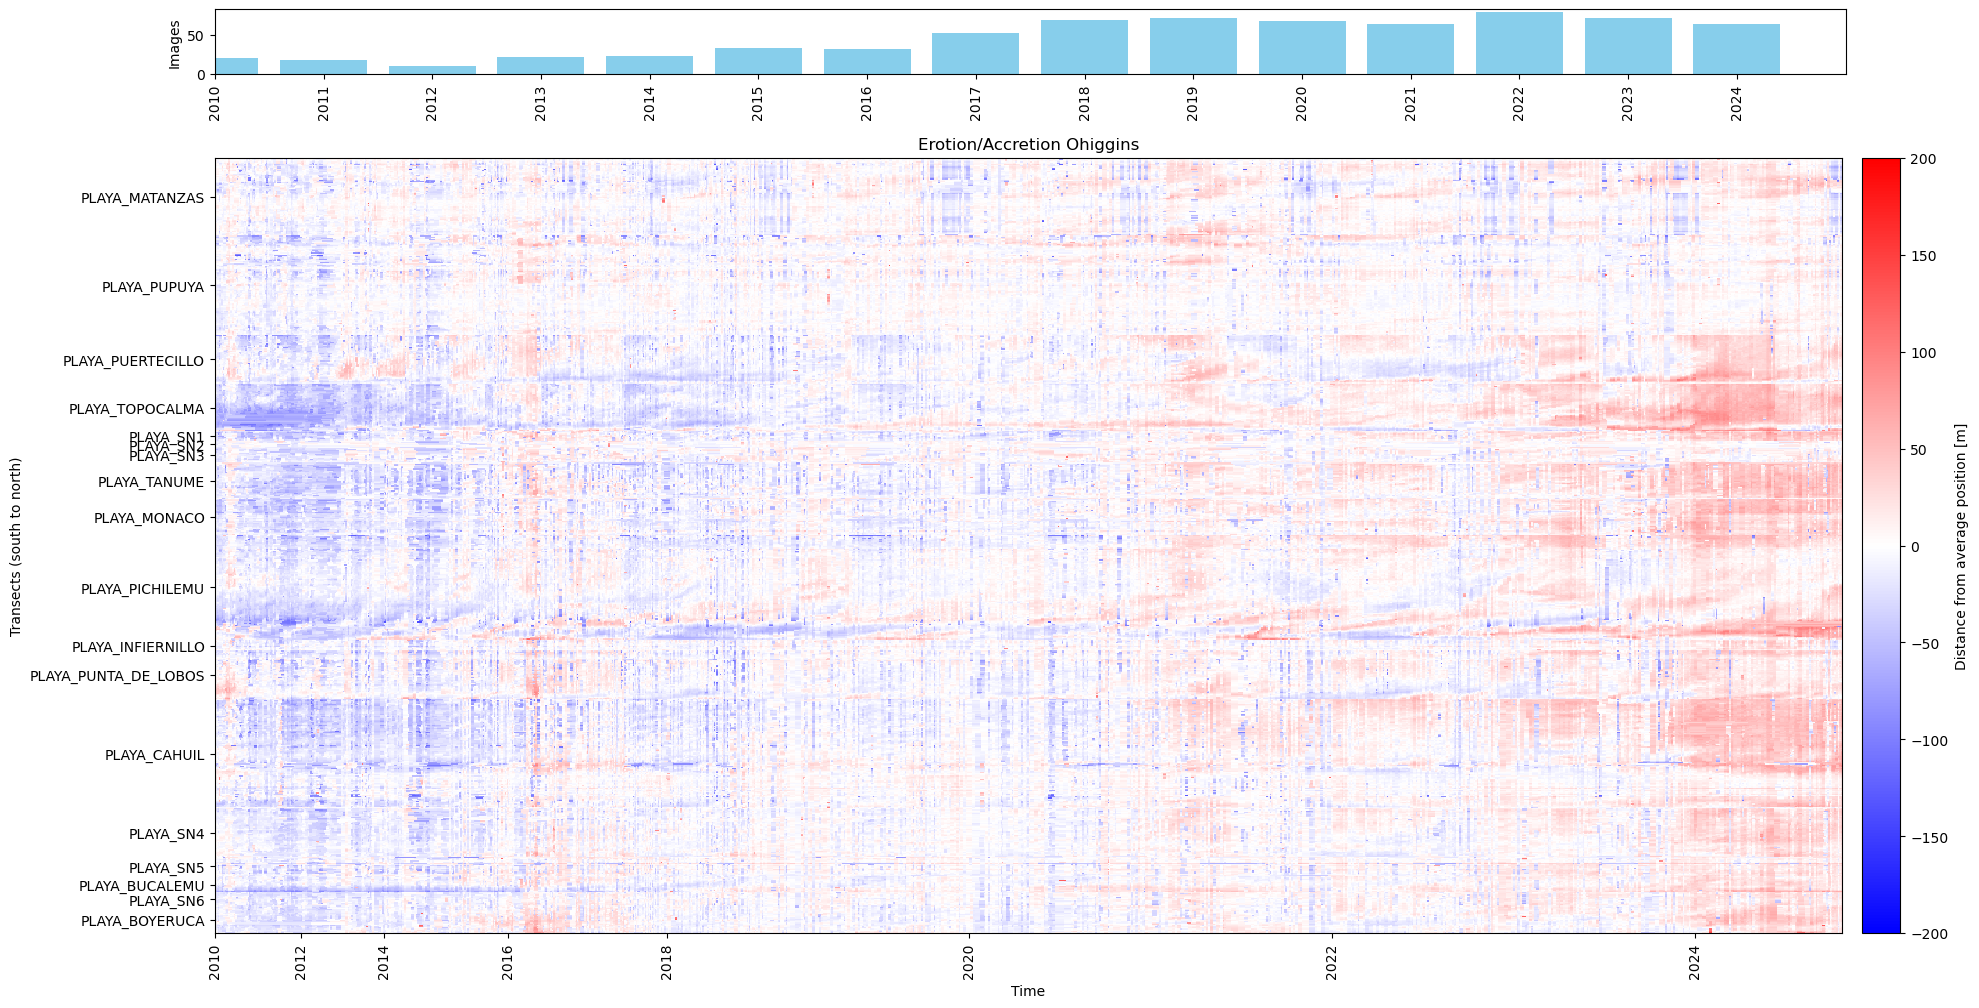

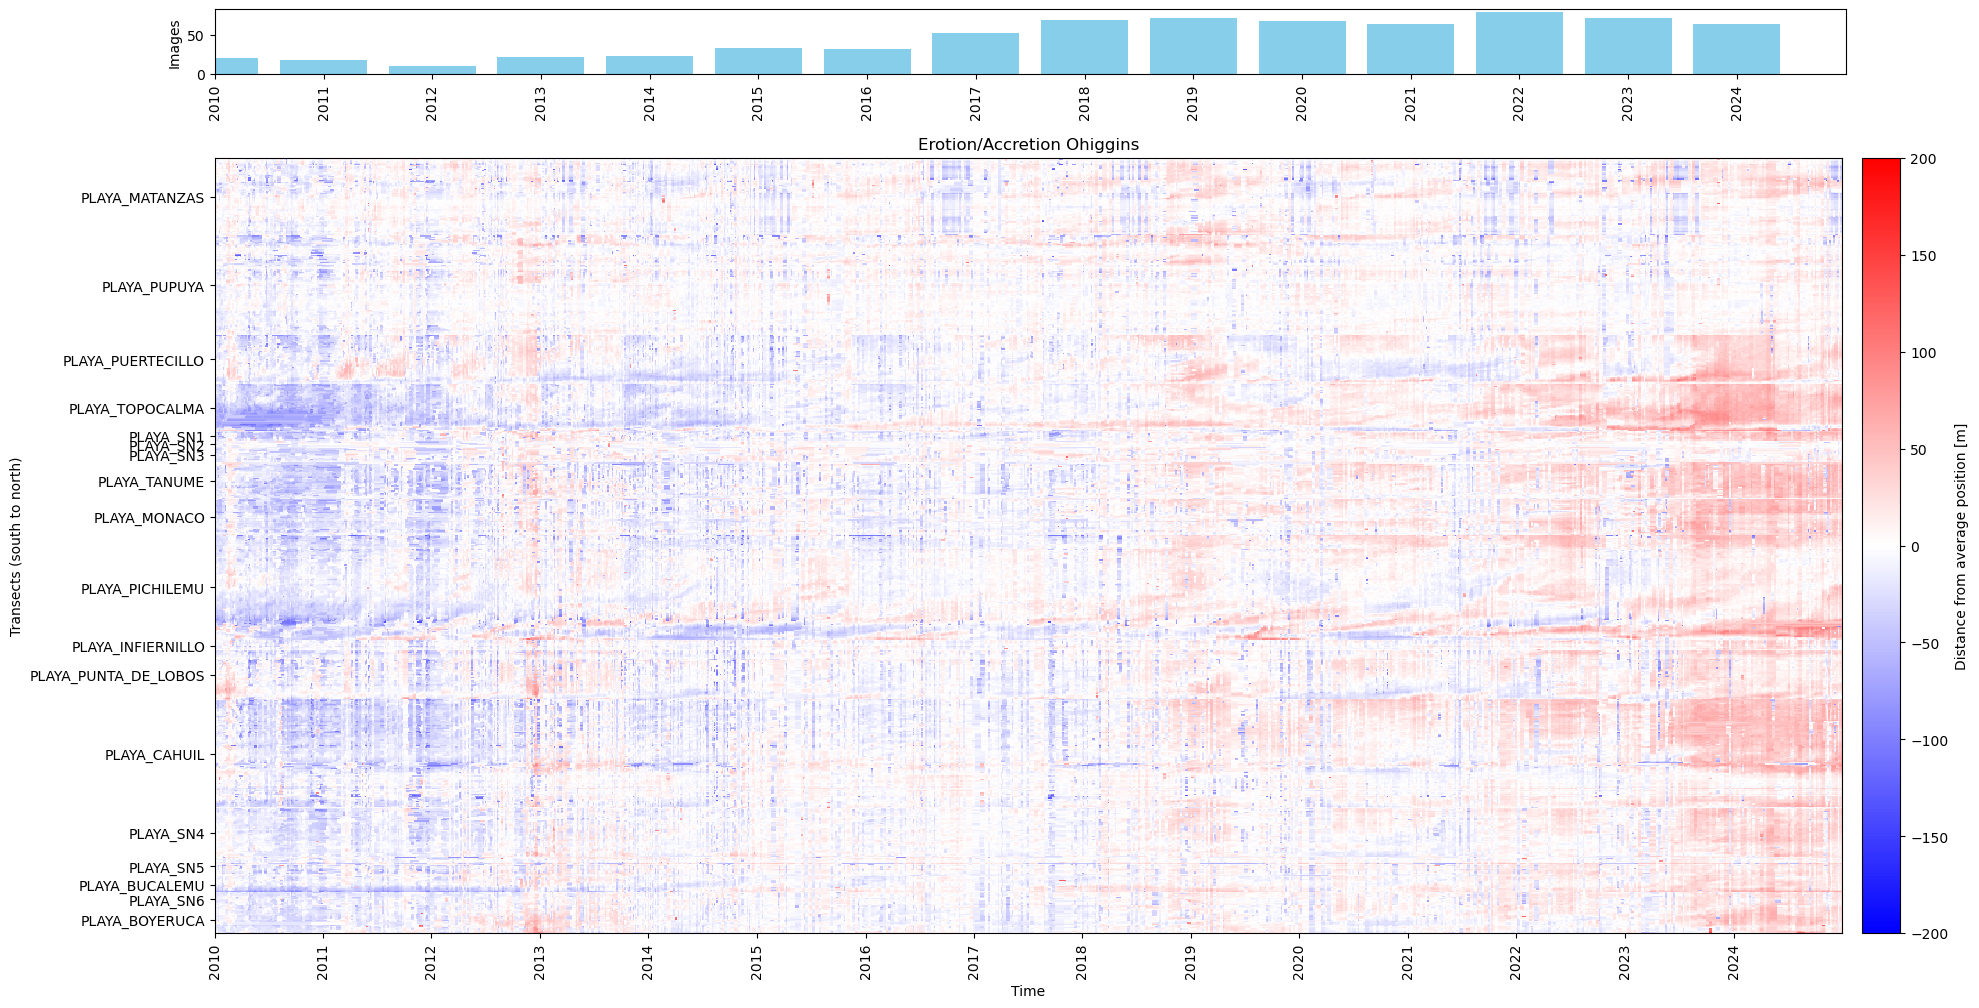

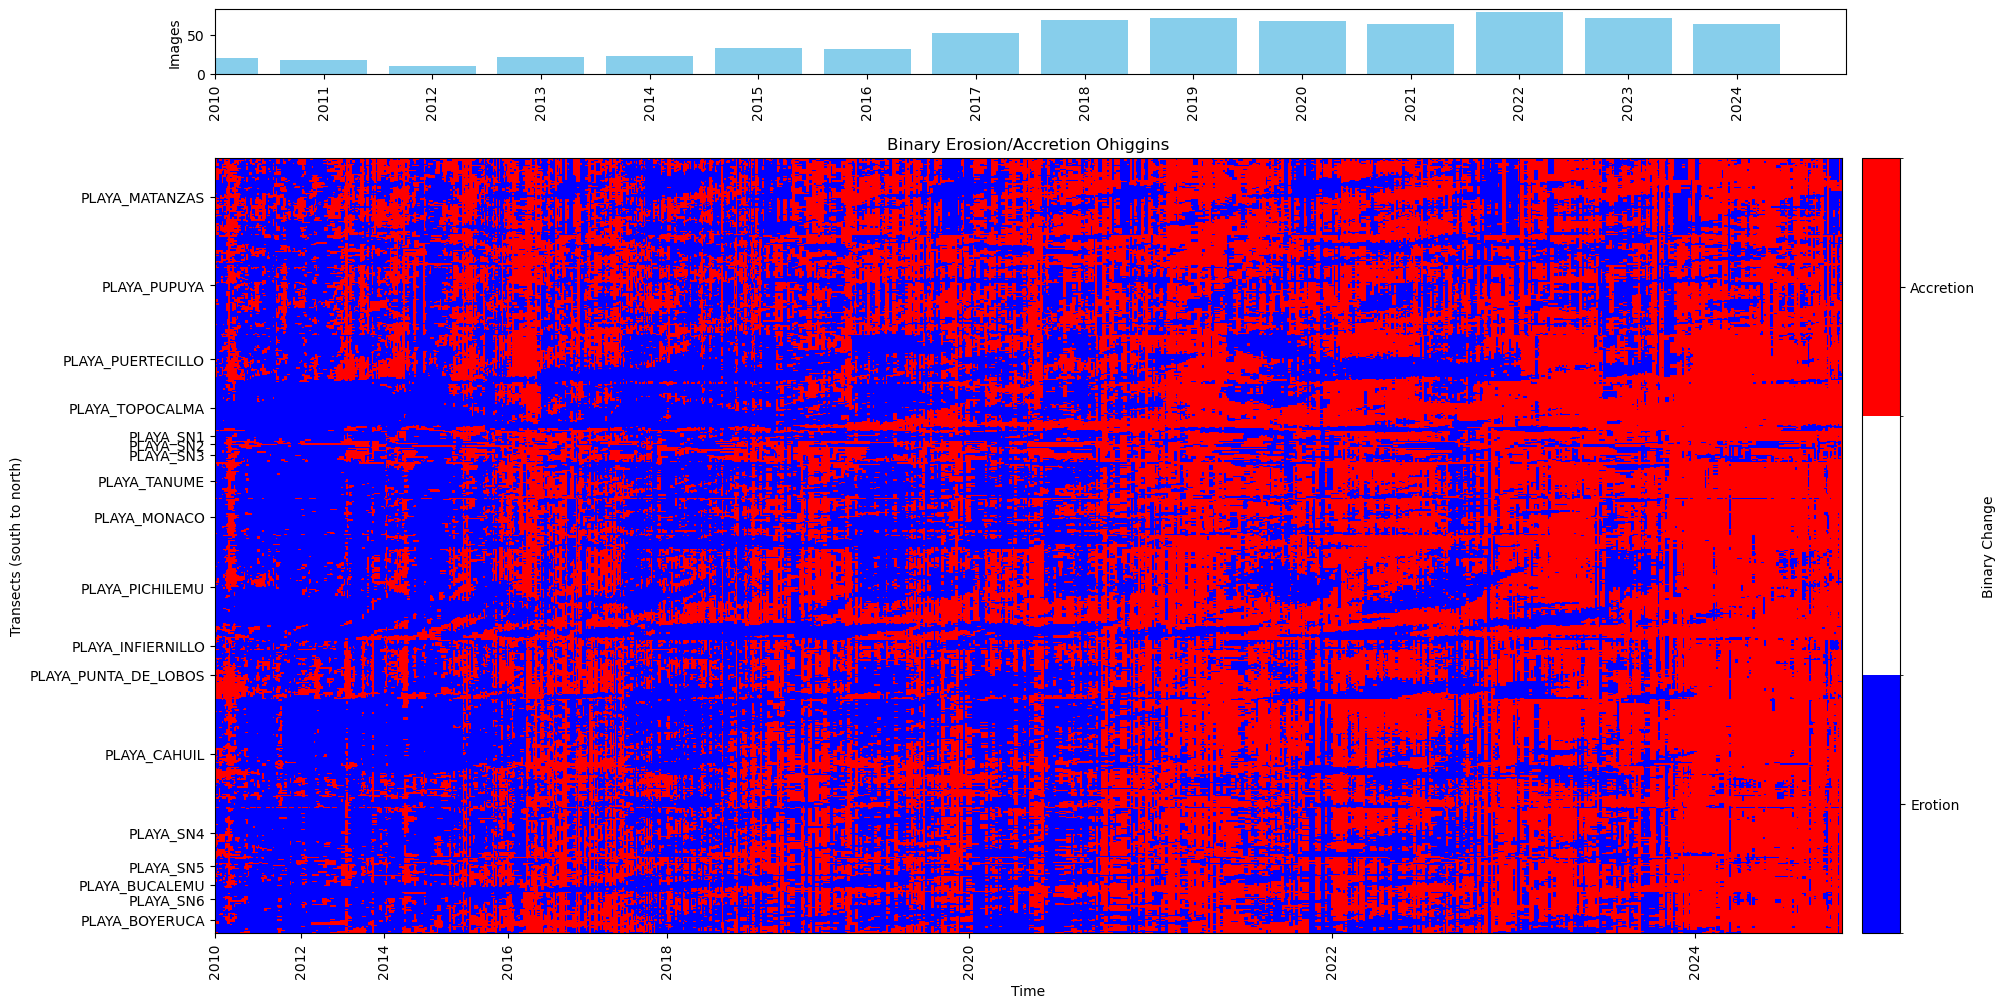

In [16]:
#Graficamos distintos escenarios

#Caso General
serie_interpolada_2010 = serie_interpolada[str(2010):str(2025)]
promedio_seccion = serie_interpolada_2010.mean()
diferencias_total = serie_interpolada_2010 - promedio_seccion

# Eliminar filas o columnas con NaN antes de calcular diferencias
diferencias_total = diferencias_total.dropna()
output_diferencias_csv_path = os.path.join(output_folder, "diferencias.csv")
output_diferencias_excel_path = os.path.join(output_folder, "diferencias.xlsx")
#diferencias_total.to_csv(output_diferencias_csv_path, index=False)
#diferencias_total.to_excel(output_diferencias_excel_path, index=False)

xt_total = erotion_accretion_xt(diferencias_total, region, ruta_resultados, lista_playas)
xt_total_equidistante = erotion_accretion_xt_equidistante(diferencias_total, region, ruta_resultados, lista_playas)
xt_total_2_binario = erotion_accretion_binario(diferencias_total, region, ruta_resultados, lista_playas)

